# Reproduces the Cytocipher pancreas analysis

### Environment setup

***The below was tested using python 3.8.12, with a new conda environment in a new empty folder, as shown below***

    mkdir cytocipher_test
    cd cytocipher_test
    conda create -n cytocipher_test python=3.8.12
    conda activate cytocipher_test

### Cytocipher installation

In [ ]:
!git clone https://github.com/BradBalderson/Cytocipher.git
!pip install -r Cytocipher/requirements.txt
!pip install --no-deps scanpy==1.9.1
!pip install scvelo==0.2.4

In [1]:
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

import sys
cc_path = 'Cytocipher/'
sys.path.append( cc_path )
import cytocipher as cc

### Downloading data & preprocessing 

Following the magnificent scvelo tutorial here:
https://scvelo.readthedocs.io/VelocityBasics/

In [2]:
data = scv.datasets.pancreas()

Preprocessing

In [3]:
scv.pp.filter_genes(data, min_shared_counts=4)
scv.pp.normalize_per_cell(data)
scv.pp.log1p(data)

print(data.shape)

Filtered out 18138 genes that are detected 4 counts (shared).
Normalized count data: X, spliced, unspliced.
(3696, 9860)


### Reproduce scvelo velocity embedding for reference

In [ ]:
scv.pp.moments(data, n_pcs=30, n_neighbors=30)
scv.tl.velocity(data)
scv.tl.velocity_graph(data)

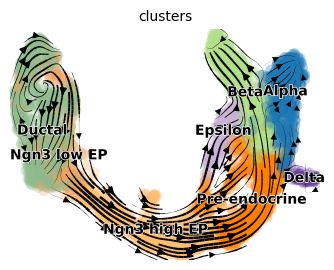

In [13]:
scv.pl.velocity_embedding_stream(data, basis='umap', figsize=(4,3))

### Over-clustering

In [14]:
sc.tl.leiden(data, resolution=3.5)

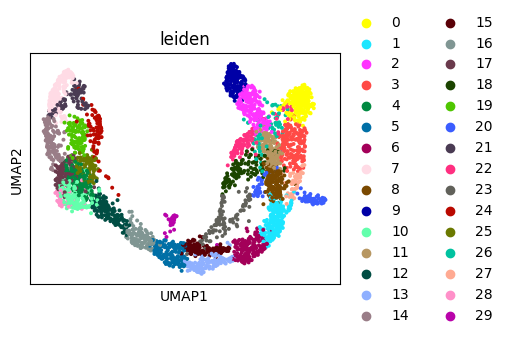

In [15]:
_, ax = plt.subplots(figsize=(4,3))
sc.pl.umap(data, color='leiden', ax=ax)

# Running Cytocipher to determine significantly different clusters

### First confirm over-clustering with code-scoring

In [9]:
### Can check documentation with:
?cc.tl.code_enrich

In [16]:
sc.pp.highly_variable_genes(data, min_disp=.2)

cc.tl.get_markers(data, 'leiden', var_groups='highly_variable', n_top=6)
cc.tl.code_enrich(data, 'leiden', n_cpus=2)

Added data.uns['leiden_markers']
Added data.obsm['leiden_enrich_scores']


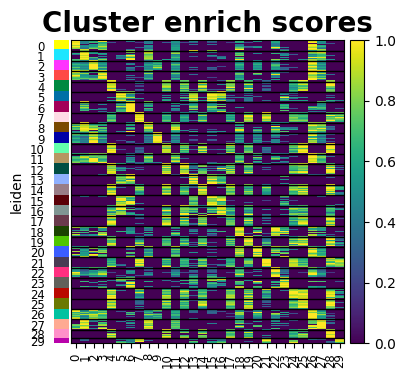

In [17]:
cc.pl.enrich_heatmap(data, 'leiden', figsize=(4,4))

## Determine significantly different clusters

In [31]:
?cc.tl.merge_clusters

In [18]:
cc.tl.merge_clusters(data, 'leiden', n_cpus=2, p_cut=.045)

Initial merge.
Added data.obs[f'leiden_merged']
Exiting due to reaching max_iter 0


In [19]:
#### Asthetic colours
colors = ['#f7b6d2','#d62728','#aec7e8','#9edae5','#2ca02c','#ff9896','#ffbb78',
          '#8c564b','#1f77b4','#c5b0d5','#bcbd22','#c7c7c7','#17becf','#e377c2']
orig_colors = {str(i): color for i, color in enumerate(colors)}
clust_map = {'0': '5', '1': '0', '2': '2', '3': '1', '4': '3', '5': '4', '6': '10',
            '7': '6', '8': '8', '9': '9', '10': '11', '11': '12', '12': '14', '13': '15'}
new_colors = {clust_map[clust]: orig_colors[clust] for clust in orig_colors}
new_colors['7'] = 'wheat'
new_colors['13'] = 'salmon'

data.uns['leiden_merged_colors'] = [new_colors[clust] for clust in list(data.obs['leiden_merged'].cat.categories)]

### Visualise the merged clusters

Important to make sure the cluster merging makes sense; for instance, we should not see clusters merged that are highly distint in the UMAP space, and the cluster code scores should look distinct for each cluster.

Below, we can see cytocipher cluster merge has identified interesting intermediate states in pancreas differentiation.

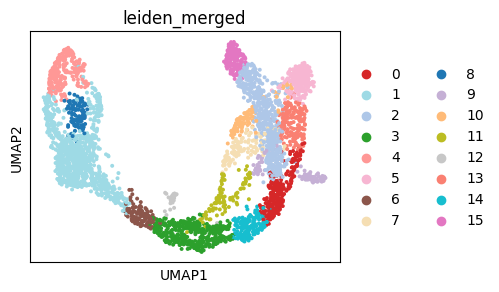

In [20]:
_, ax = plt.subplots(figsize=(4,3))
sc.pl.umap(data, color=f'leiden_merged', ax=ax)

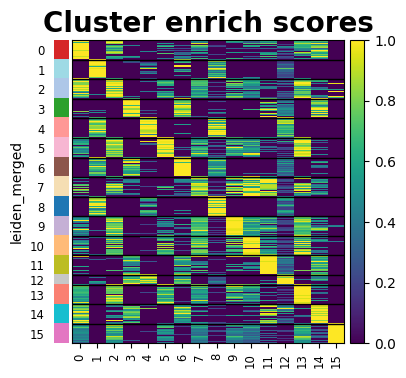

In [21]:
cc.pl.enrich_heatmap(data, 'leiden_merged', figsize=(4,4), scale_cols=True)

Can visualise which clusters were merged.

In [33]:
?cc.pl.merge_sankey

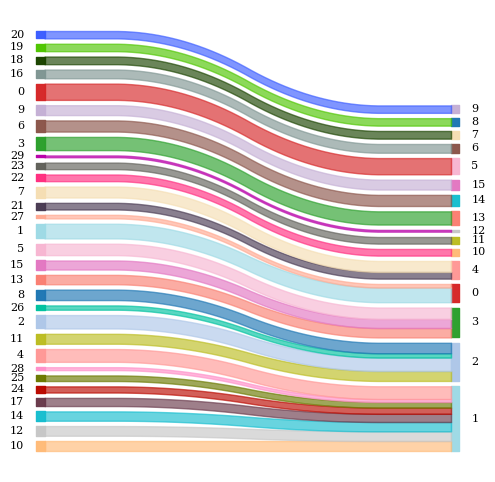

In [22]:
cc.pl.merge_sankey(data, 'leiden')

### Checking the p-value cutoff

Too relaxed (high p_cut), then clearly different clusters will be merged.

Too stringent (low p_cut), then clusters which are very similar may not be merged.

In the volcano plot below, the p-value cutoff of .05 appears to create a good separation of significant vs non-significant cluster pairs such that most of the non-significant cluster pairs also have a much lower log-FC for the enrichment scores.

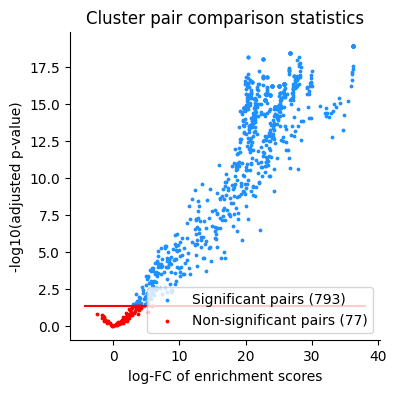

In [24]:
cc.pl.volcano(data, 'leiden', p_cut=.045, p_adjust=True, figsize=(4,4))

If we want to adjust this, can do so quickly by running:

In [27]:
?cc.tl.merge

In [25]:
cc.tl.merge(data, 'leiden', p_cut=0.045, use_p_adjust=True)

Added data.uns['leiden_mutualpairs']
Added data.obs['leiden_merged']


Need to update the marker genes and the scores to ensure these are in-sync with the updated merged cluster labels:

In [28]:
cc.tl.get_markers(data, 'leiden_merged', var_groups='highly_variable', n_top=6)
cc.tl.code_enrich(data, 'leiden_merged', n_cpus=2)

Added data.uns['leiden_merged_markers']
Added data.obsm['leiden_merged_enrich_scores']


***This is also evident when examining the distributions for the comparisons made when testing for cluster significant difference.***

'Bottom significant' has a low p-value for one direction of cluster comparion (p=0.008), while the 'Bottom non-significant' has high p-values when comparing clusters in both directions (p=0.1089 & p=0.1297).

Thus indicating a good separaton between significant versus non-significant pairs.

Printing top and bottom most significant/non-significant clusters.

Top significant
p=2.373953787511573e-21 (9 cells; 9 scores) vs (1 cells; 9 scores)
p=1.6886623129604666e-10 (9 cells; 1 scores) vs (1 cells; 1 scores)


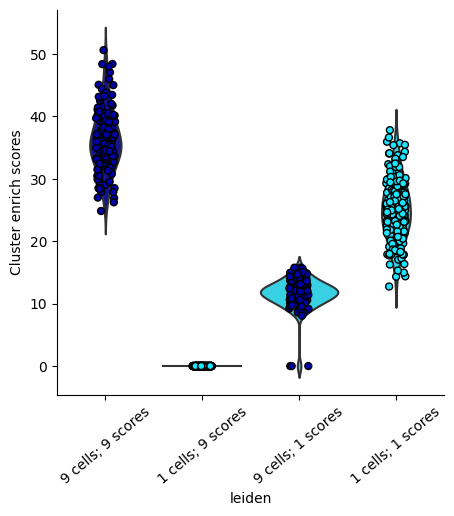

Bottom significant
p=0.9330751553043308 (26 cells; 26 scores) vs (20 cells; 26 scores)
p=1.786090242867995e-09 (26 cells; 20 scores) vs (20 cells; 20 scores)


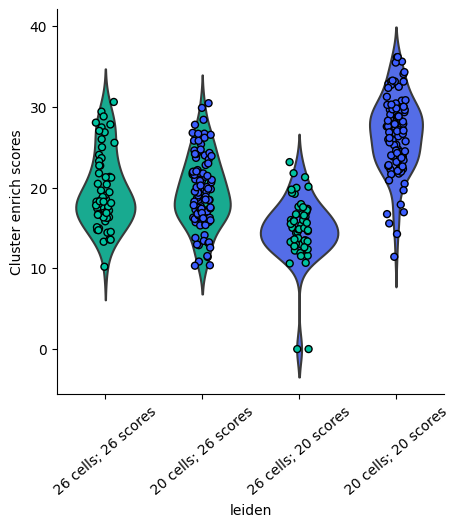

Top non-significant
p=0.9959347222234254 (17 cells; 17 scores) vs (4 cells; 17 scores)
p=0.5147088387085947 (17 cells; 4 scores) vs (4 cells; 4 scores)


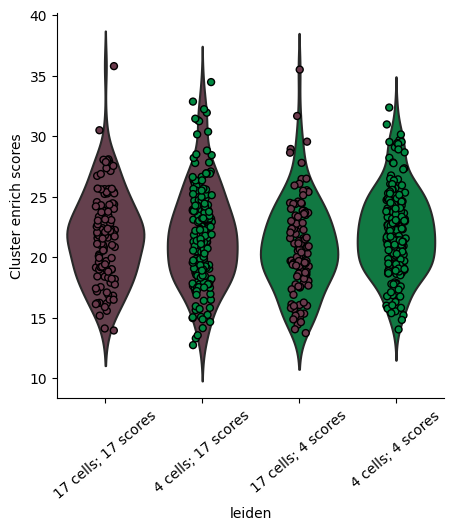

Bottom non-significnat
p=0.043690278748269896 (24 cells; 24 scores) vs (25 cells; 24 scores)
p=0.04461398211148797 (24 cells; 25 scores) vs (25 cells; 25 scores)


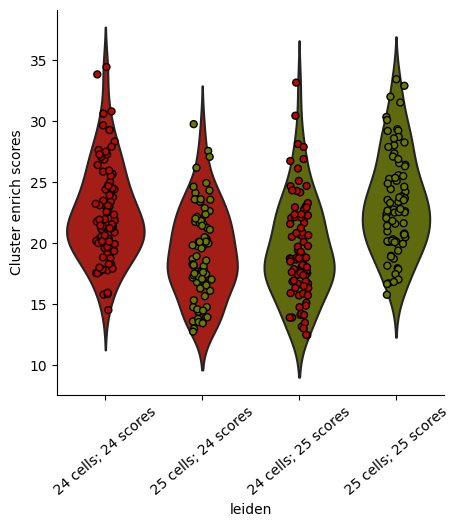

In [29]:
cc.pl.sig_cluster_diagnostics(data, 'leiden')

## Checking for cluster size bias

Ideally, we do not want the number of cells in each cluster to effect the significance. 

Below we plot the log-FC between the number of cells in the clusters being compared on the x-axis,
with the -log10(p-values) for the pair significance comparison as the y-axis. 

If a correlation is observed, this could indicate something has gone wrong in the cluster merging function above.

ρ indicates the Spearman correlation on a scale of -1 to 1, with 0 indicating no bias/correlation. In this case, ρ=0.02 indicates negligible correlation between cluster pair significance & cell abundance, & therefore no bias.

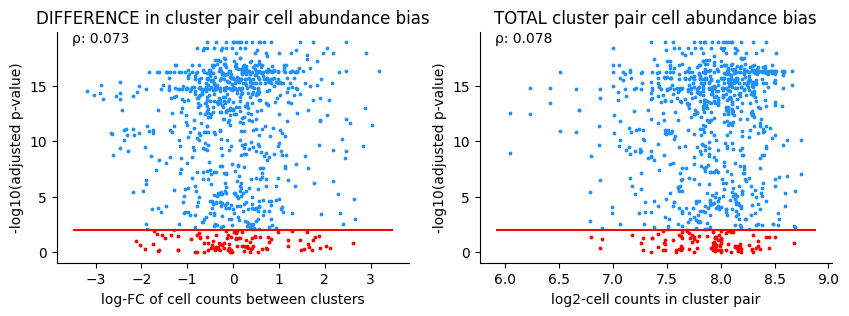

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(10,3))
cc.pl.check_abundance_bias(data, 'leiden', p_cut=1e-2, p_adjust=True, show_legend=False, ax=ax[0], show=False)
cc.pl.check_total_abundance_bias(data, 'leiden', p_cut=1e-2, p_adjust=True, show_legend=False, ax=ax[1], show=False)
plt.show()

## Examining the expression of the top marker genes for the merged clusters

We can also look at the top marker genes for each of the merged clusters.

When visualising these & reading literature on the role of these genes in pancreas development, it's clear the new states identified correspond to important intermediate states and branch points in pancreatic cell fate determination.

In [31]:
markers = data.uns['leiden_merged_markers']
markers

{'0': array(['Chgb', 'Fev', 'Hmgn3', 'Chga', 'Cpe', 'Bex2'], dtype=object),
 '1': array(['Spp1', 'Sparc', 'Clu', 'Dbi', 'Mgst1', 'Anxa2'], dtype=object),
 '2': array(['1700086L19Rik', 'Rbp4', 'Cpe', 'Rap1b', 'Pcsk1n', 'Chgb'],
       dtype=object),
 '3': array(['Btbd17', 'Mdk', 'Tmsb4x', 'Neurog3', 'Gadd45a', 'Btg2'],
       dtype=object),
 '4': array(['Tuba1b', 'Hmgb2', 'Tubb5', 'H2afz', '2810417H13Rik', 'Spp1'],
       dtype=object),
 '5': array(['Cpe', 'Pcsk1n', 'Tmem27', 'Pcsk2', 'Gpx3', 'Slc38a5'],
       dtype=object),
 '6': array(['Neurog3', 'Cd24a', 'Btbd17', 'Gadd45a', 'Mdk', 'Serpinh1'],
       dtype=object),
 '7': array(['Isl1', 'Fam183b', 'Aplp1', 'Rbp4', 'Bex2', 'Gch1'], dtype=object),
 '8': array(['Pebp1', 'Gapdh', 'Wfdc2', 'Spp1', 'Rpl12', 'Mgst1'], dtype=object),
 '9': array(['Rbp4', 'Isl1', 'Hmgn3', 'Hhex', 'Fam183b', 'Hadh'], dtype=object),
 '10': array(['Rbp4', 'Isl1', 'Aplp1', 'Ghrl', 'Bex2', 'Tmed10'], dtype=object),
 '11': array(['Cdkn1a', 'Rgs17', 'Isl1', 'Krt7',

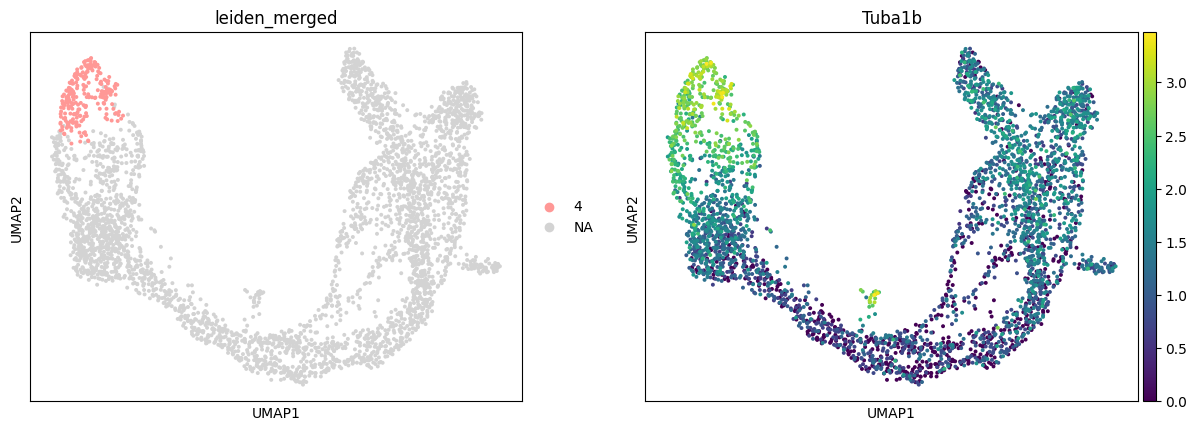

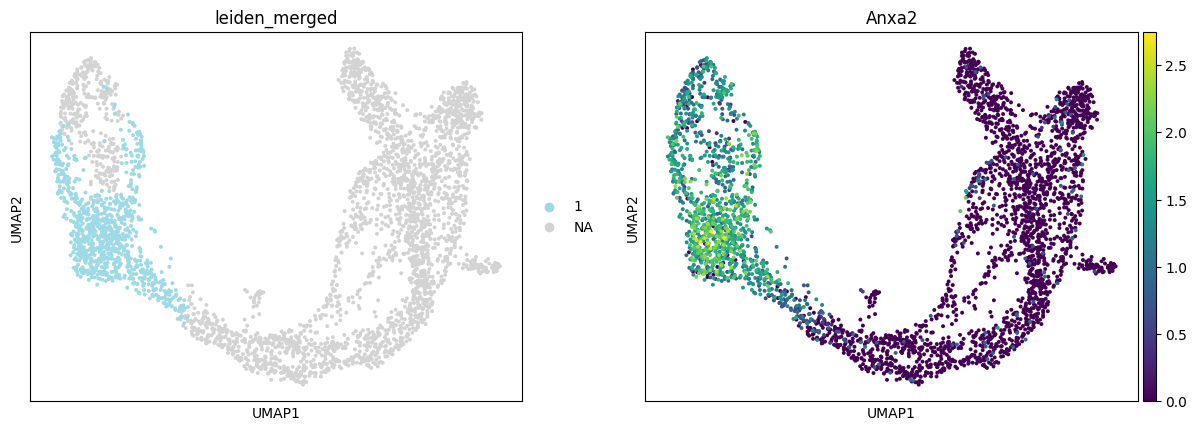

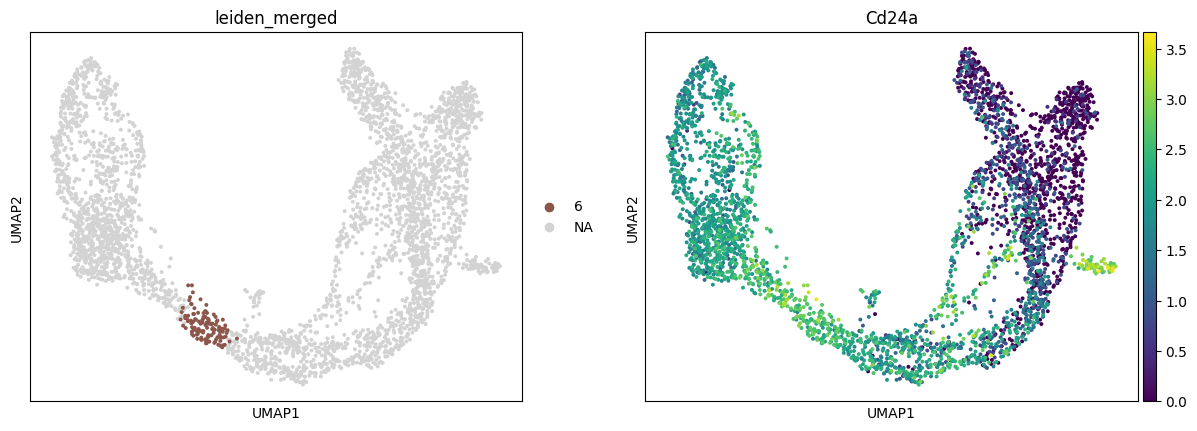

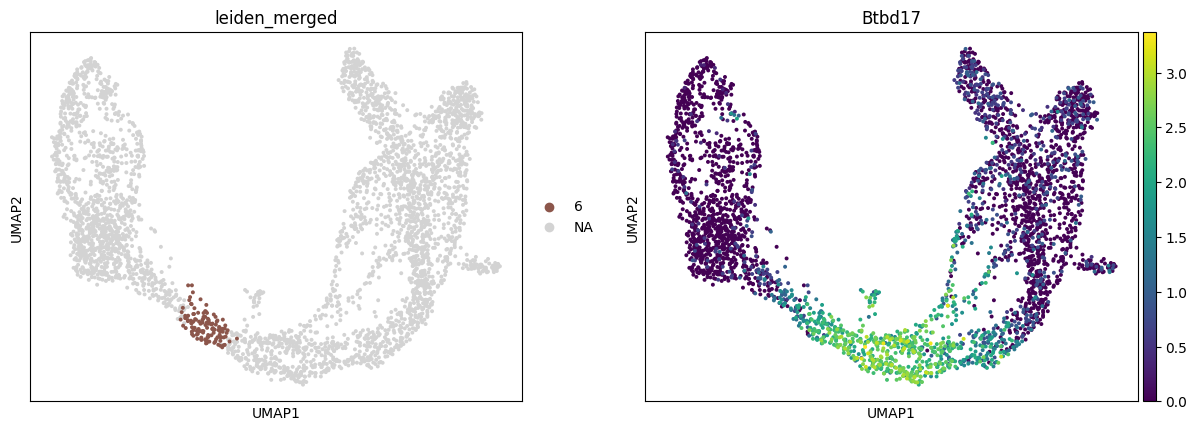

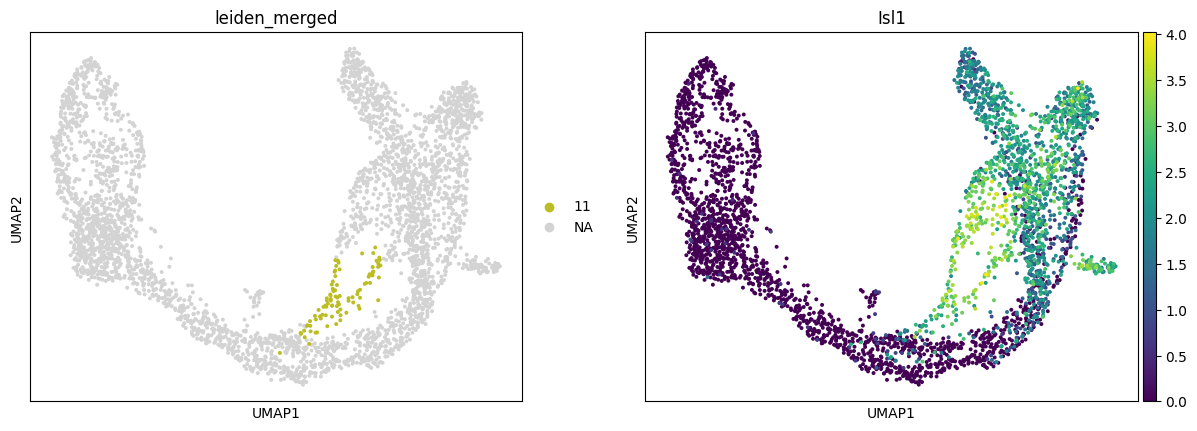

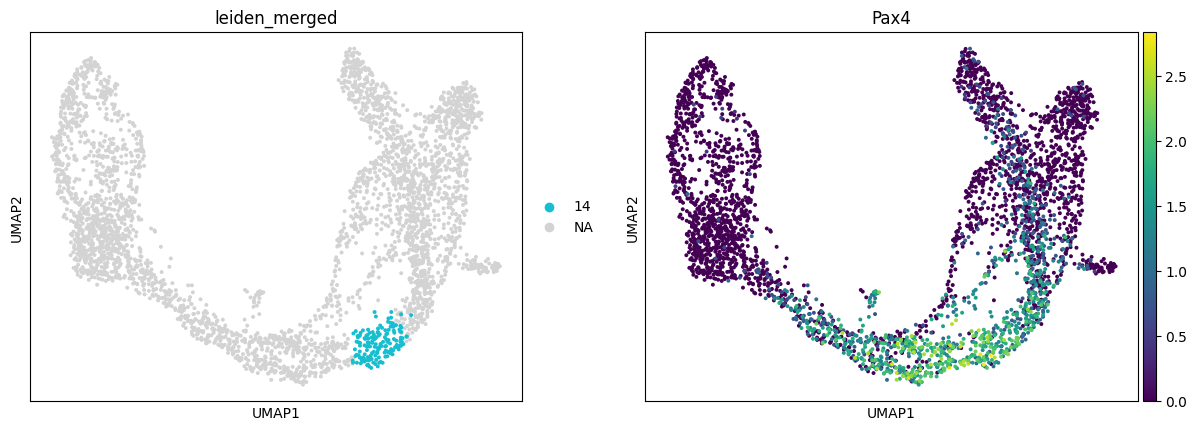

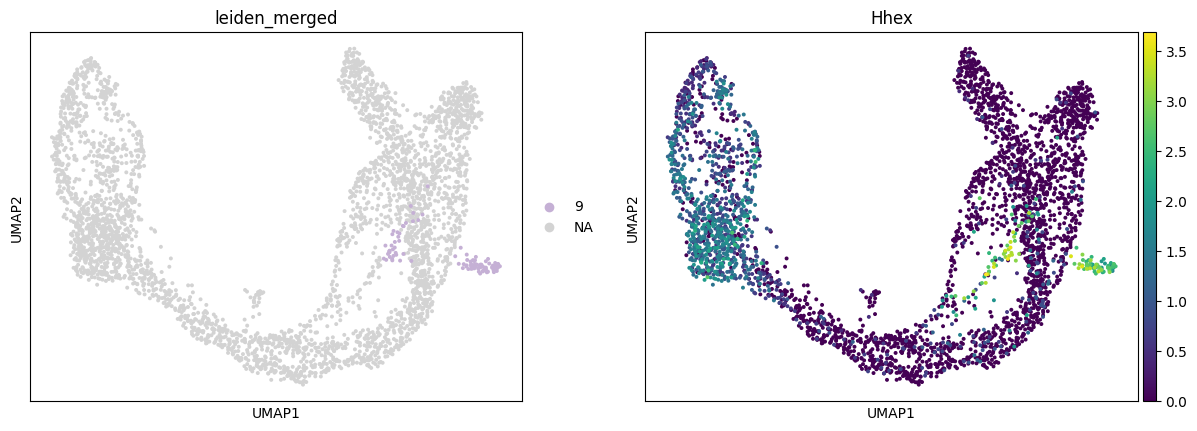

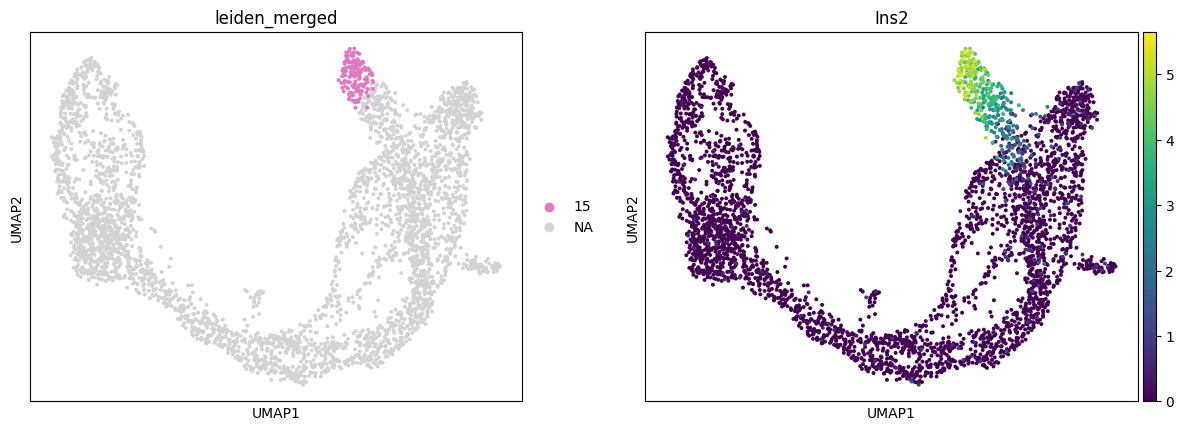

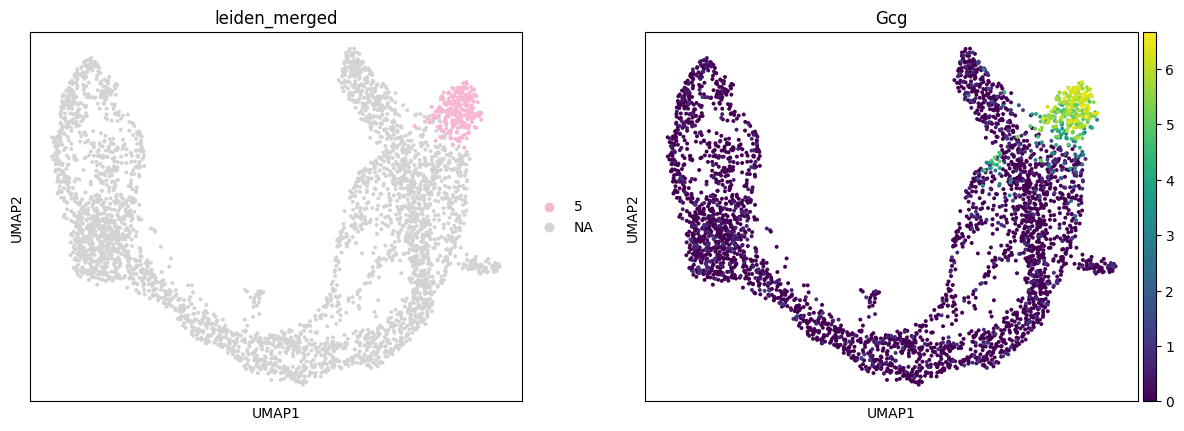

In [32]:
interesting_markers = ['Tuba1b', 'Anxa2', 'Cd24a', 'Btbd17', 'Isl1', 'Pax4', 'Hhex', 'Ins2', 'Gcg']
clusters = ['4', '1', '6', '6', '11', '14', '9', '15', '5']
for i in range(len(clusters)):
    sc.pl.umap(data, color=['leiden_merged', interesting_markers[i]], groups=[clusters[i]])

### Thanks for taking a look, please feel free to add an issue to the github page if you find problems!

https://github.com/BradBalderson/Cytocipher